In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.datasets import fetch_20newsgroups, fetch_20newsgroups_vectorized
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

%matplotlib inline

Get news groups and emails. This will be training data. Note: this took me about 13 mins to download

In [2]:
news = fetch_20newsgroups()

In [3]:
news.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR', 'description'])

In [4]:
news_df = pd.DataFrame()
news_df['text'] = news.data
news_df['group_num'] = news.target
news_df['group'] = (news_df['group_num']
                    .apply(lambda x: news['target_names'][x]))

Take a peak at what our dataset looks like in a table

In [5]:
news_df.sample(5)

,text,group_num,group
7653,From: debbie@csd4.csd.uwm.edu (Debbie Forest)\...,13,sci.med
6908,From: dchien@hougen.seas.ucla.edu (David H. Ch...,14,sci.space
3517,From: rene@hardy.u.washington.edu (Rene Magrit...,2,comp.os.ms-windows.misc
3856,Organization: University of Illinois at Chicag...,16,talk.politics.guns
8654,From: ronaldm@extro.ucc.su.OZ.AU (Ron Mastus)\...,3,comp.sys.ibm.pc.hardware


What are the groups of topics that we are exploring?

In [6]:
news_df['group'].unique()

array(['rec.autos', 'comp.sys.mac.hardware', 'comp.graphics', 'sci.space',
       'talk.politics.guns', 'sci.med', 'comp.sys.ibm.pc.hardware',
       'comp.os.ms-windows.misc', 'rec.motorcycles', 'talk.religion.misc',
       'misc.forsale', 'alt.atheism', 'sci.electronics', 'comp.windows.x',
       'rec.sport.hockey', 'rec.sport.baseball', 'soc.religion.christian',
       'talk.politics.mideast', 'talk.politics.misc', 'sci.crypt'], dtype=object)

In [7]:
news_df.shape

(11314, 3)

Instantiate the TFIDF so that we can create a matrix of weights

In [8]:
tfidf_vectorizer = TfidfVectorizer(min_df = 1, stop_words = 'english')
document_term_matrix = tfidf_vectorizer.fit_transform(news_df['text'])

In [9]:
document_term_matrix

<11314x129796 sparse matrix of type '<class 'numpy.float64'>'
	with 1300729 stored elements in Compressed Sparse Row format>

Run singular value decomposition on that matrix

In [34]:
SVD = TruncatedSVD(10)
latent_semantic_analysis = SVD.fit_transform(document_term_matrix)

Now let's check our predictive power by typing in a search term

In [35]:
search_term = "stock prices"

Then we find a cosine similarity between that search term and our decomposed document matrix

In [36]:
search_term_vec = tfidf_vectorizer.transform([search_term])
search_term_lsa = SVD.transform(search_term_vec)

In [37]:
cosine_similarities = latent_semantic_analysis.dot(search_term_lsa.T).ravel()

Then we sort by the top 5 

In [38]:
cosine_similarities.argsort()[:-6:-1]

array([3375, 7722, 6079, 3645, 8166])

Now to check, we enter a number from that array, and display the first 500 characters

In [39]:
print(news_df.loc[3375]['text'][:500])

From: wlsmith@valve.heart.rri.uwo.ca (Wayne Smith)
Subject: Re: IDE vs SCSI
Organization: The John P. Robarts Research Institute, London, Ontario
Nntp-Posting-Host: valve.heart.rri.uwo.ca
Lines: 141

In article <C5LKEv.HpJ@feanor.xel.com> shaw@feanor.xel.com (Greg Shaw) writes:
>: Why don't you start with the spec-sheet of the ISA bus first?
>: You can quote SCSI specs till you're blue in the face, but if they
>: exceed the ISA bus capability, then what's the point?
>
>Who said ISA was necessary


Now lets see if a random search term is included in our text, to test.

In [40]:
"Business" in news_df.loc[3375]['text']

False

Display the first 1000 characters of our document

In [41]:
print(news_df.loc[3375]['text'][:1000])

From: wlsmith@valve.heart.rri.uwo.ca (Wayne Smith)
Subject: Re: IDE vs SCSI
Organization: The John P. Robarts Research Institute, London, Ontario
Nntp-Posting-Host: valve.heart.rri.uwo.ca
Lines: 141

In article <C5LKEv.HpJ@feanor.xel.com> shaw@feanor.xel.com (Greg Shaw) writes:
>: Why don't you start with the spec-sheet of the ISA bus first?
>: You can quote SCSI specs till you're blue in the face, but if they
>: exceed the ISA bus capability, then what's the point?
>
>Who said ISA was necessary?  EISA or VLB are the only interfaces worth
>investing thousands of dollars (e.g. a new pc's worth of money ) in .

Then don't complain (maybe it wasn't you) that SCSI was so expensive on
PC's because all we've had until a year or two ago was the ISA bus.
(ie no one buys SCSI for ISA because ISA is slow)
Are you saying that SCSI on an ISA bus is not an automatic winner when
compared to IDE?

>You didn't read to carefully.  VLB-IDE uses the same connection mechanism
>as standard IDE.  If transfe

In [42]:
news_df.groupby('group').count()

,text,group_num
group,,
alt.atheism,480,480
comp.graphics,584,584
comp.os.ms-windows.misc,591,591
comp.sys.ibm.pc.hardware,590,590
comp.sys.mac.hardware,578,578
comp.windows.x,593,593
misc.forsale,585,585
rec.autos,594,594
rec.motorcycles,598,598


Let's try the same idea, but use k-Nearest Neighbors as our model. We'll also GridSearch so that we can figure out best parameters

In [43]:
KNN = KNeighborsClassifier()
gs = GridSearchCV(KNN, param_grid={'n_neighbors':range(2,20)})
gs.fit(latent_semantic_analysis, news_df['group_num'])

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': range(2, 20)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

How long did that take? What's our score? 

In [44]:
gs_res_df = pd.DataFrame(gs.cv_results_)
gs_res_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
mean_fit_time,0.0101846,0.0116348,0.00875123,0.00865523,0.00880162,0.0114128,0.0105908,0.00887362,0.0103253,0.0096813,0.00869338,0.0089968,0.00966183,0.00871976,0.00879002,0.0105874,0.00878294,0.00883532
mean_score_time,0.18527,0.180694,0.173248,0.182894,0.19689,0.238574,0.23999,0.216526,0.240379,0.227117,0.229018,0.236688,0.241212,0.241322,0.252902,0.251421,0.255422,0.25778
mean_test_score,0.499735,0.517854,0.53288,0.538625,0.545519,0.552413,0.553739,0.557716,0.559572,0.556655,0.558423,0.559749,0.557628,0.555418,0.554711,0.554623,0.55312,0.552413
mean_train_score,0.757513,0.727726,0.707443,0.691578,0.676418,0.664883,0.655118,0.647781,0.640976,0.634126,0.632313,0.627585,0.623741,0.62131,0.61941,0.615035,0.612117,0.613001
param_n_neighbors,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
params,{'n_neighbors': 2},{'n_neighbors': 3},{'n_neighbors': 4},{'n_neighbors': 5},{'n_neighbors': 6},{'n_neighbors': 7},{'n_neighbors': 8},{'n_neighbors': 9},{'n_neighbors': 10},{'n_neighbors': 11},{'n_neighbors': 12},{'n_neighbors': 13},{'n_neighbors': 14},{'n_neighbors': 15},{'n_neighbors': 16},{'n_neighbors': 17},{'n_neighbors': 18},{'n_neighbors': 19}
rank_test_score,18,17,16,15,14,12,10,4,2,6,3,1,5,7,8,9,11,12
split0_test_score,0.498543,0.511258,0.525563,0.532715,0.543576,0.550464,0.554172,0.553907,0.557616,0.550464,0.553113,0.553113,0.553113,0.550993,0.549934,0.549404,0.545695,0.543576
split0_train_score,0.758323,0.733917,0.708847,0.693195,0.680594,0.666003,0.660167,0.64929,0.642393,0.636822,0.63271,0.628996,0.628863,0.623955,0.622762,0.618384,0.612813,0.613211
split1_test_score,0.508614,0.526372,0.538033,0.546515,0.553936,0.559237,0.560827,0.563212,0.566393,0.565598,0.567188,0.566923,0.567983,0.567188,0.562417,0.562417,0.561887,0.562682


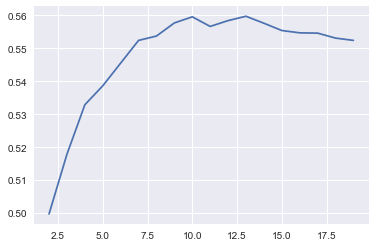

In [46]:
plt.plot(gs_res_df['param_n_neighbors'], gs_res_df['mean_test_score'])

In [21]:
gs.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')

In [47]:
gs.predict(search_term_lsa)

array([2])

In [48]:
news.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR', 'description'])

In [49]:
news['target_names']

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Let's try SVD with a larger n_components

In [50]:
SVD = TruncatedSVD(200)
latent_semantic_analysis = SVD.fit_transform(document_term_matrix)

<Container object of 200 artists>

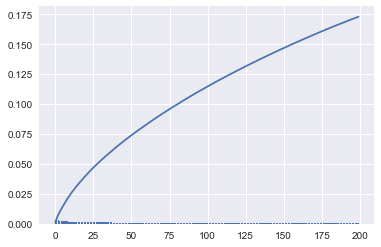

In [51]:
evr = SVD.explained_variance_ratio_
x = list(range(len(evr)))
plt.plot(x, np.cumsum(evr))
plt.bar(x, evr)

Pickle our news dataset

In [52]:
news_df.to_pickle('news.p')

In [53]:
type(document_term_matrix)

scipy.sparse.csr.csr_matrix

In [54]:
import scipy.sparse as sparse
import scipy.io
import numpy as np

def save_sparse_matrix(filename, x):
    x_coo = x.tocoo()
    row = x_coo.row
    col = x_coo.col
    data = x_coo.data
    shape = x_coo.shape
    np.savez(filename, row=row, col=col, data=data, shape=shape)

In [55]:
save_sparse_matrix('dtm', document_term_matrix)

In [56]:
save_sparse_matrix('stock prices', search_term_vec)

Save our tfidif as a joblib

In [57]:
from sklearn.externals import joblib

In [58]:
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer')

['tfidf_vectorizer']